# 1-day Ahead Multi-Step PV Power Prediction from Weather and Production Multi-Variate History Data

This project aims at predicting 1-day ahead PV power generation from historical power production and weather data.

## Data Availability

The datasets used in this project are:
  -  History of power production from [https://scandav.pythonanywhere.com/](https://scandav.pythonanywhere.com/) in a form of a database.
  -  History of weather conditions scraped from [https://it.tutiempo.net](https://it.tutiempo.net). For more info, refer to `history_scraper.py` contained in the same folder as this repository.

Available data spans from `2019-10-05 00:30:00` to `2021-09-17 23:30:00`.

Below is a picture of the PV system, taken by a drone.

<img src="imgs/drone_pic.jpg" alt="Drone Picture of PV System" width="800"/>

In a preliminar way, the collected weather data refers to a location distant about 10 km from the PV production site.

![Aerial Distance](imgs/map_distance.png)

Improvement of weather data in terms of proximity will be evaluated at a later step of this project.

In [1]:
import os
import datetime
import re
import glob
import sqlite3

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import numpy as np
import pandas as pd
from pandas.tseries.frequencies import to_offset

import tensorflow as tf
from sklearn import preprocessing
from sklearn.decomposition import PCA

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


2021-10-27 13:41:18.821143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-27 13:41:18.821177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Read Photovoltaic Data

### Clean and Format

Read the PV data from the database (SQLite) and prepare for merge with weather data.

In [2]:
# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("data/pv_db.db")
df_pwr = pd.read_sql_query("SELECT * from pv_data", con)
con.close()

In [3]:
df_pwr.head()

,id,created,grid_voltage,grid_current,grid_power,invert_temp,booster_temp,pwr_peak,pwr_peak_td,nrg,nrg_td
0,1,2019-10-04 19:00:06.315083,224.6,0.0,0,30.8,30.5,6004,573,37148941,10903
1,2,2019-10-04 19:10:06.099258,223.6,0.0,0,30.6,30.0,6004,573,37148941,10903
2,3,2019-10-05 07:30:05.401174,226.7,0.1,24,20.2,18.5,6004,0,37148941,0
3,4,2019-10-05 07:40:06.007266,226.7,0.0,29,21.2,19.6,6004,32,37148942,1
4,5,2019-10-05 07:50:05.717804,226.6,0.0,72,22.0,20.8,6004,70,37148950,9


Transform `created` column to `datetime` column and set it as index. Parse hour and month fron the date index, they could be useful later.

In [4]:
df_pwr['created'] = pd.to_datetime(df_pwr['created'])
df_pwr.set_index('created', drop=True, append=False, inplace=True)
df_pwr['hour'] = df_pwr.index.hour
df_pwr['month'] = df_pwr.index.month

### Inspect and Plot

In [5]:
df_pwr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107598 entries, 2019-10-04 19:00:06.315083 to 2021-09-19 19:45:06.601546
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            107598 non-null  int64  
 1   grid_voltage  107598 non-null  float64
 2   grid_current  107598 non-null  float64
 3   grid_power    107598 non-null  int64  
 4   invert_temp   107598 non-null  float64
 5   booster_temp  107598 non-null  float64
 6   pwr_peak      107598 non-null  int64  
 7   pwr_peak_td   107598 non-null  int64  
 8   nrg           107598 non-null  int64  
 9   nrg_td        107598 non-null  int64  
 10  hour          107598 non-null  int64  
 11  month         107598 non-null  int64  
dtypes: float64(4), int64(8)
memory usage: 10.7 MB


As displayed below, the grid power [W] is higher for the central months of the year. One could also note that - thanks to increased day duration - the production spans from 5:00 to 22:00 during summer. This will also be the threshold used for the data sampling.

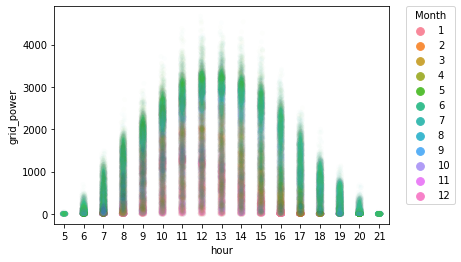

In [6]:
ax = sns.stripplot(x="hour", y="grid_power", hue="month", data=df_pwr, alpha=0.01)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Month')

The plot below shows a higher variability of power generation for the central hours of the day.

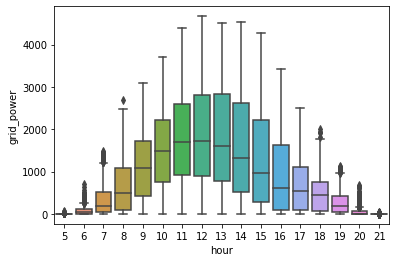

In [7]:
ax = sns.boxplot(x="hour", y="grid_power", data=df_pwr)

<AxesSubplot:xlabel='created'>

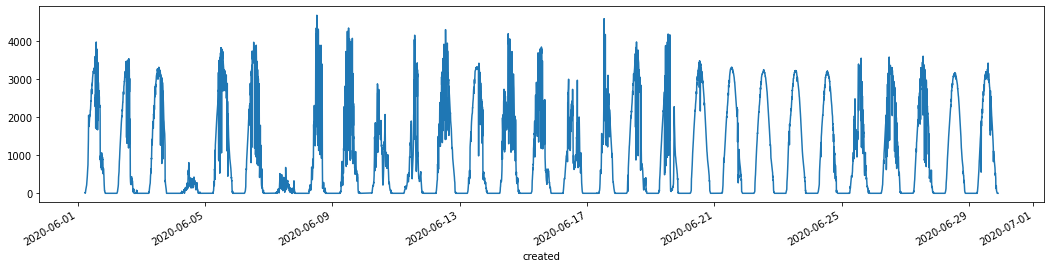

In [8]:
series_pwr = df_pwr['grid_power']

start_date = "2020-6-1"
end_date = "2020-6-30"

after_start_date = series_pwr.index >= start_date
before_end_date = series_pwr.index <= end_date
between_two_dates = after_start_date & before_end_date
series_pwr[between_two_dates].plot(figsize=(18, 4))

### Resample data

Data is resampled to hours to match the sampling from the weather history dataset

In [9]:
series_pwr_resampled = series_pwr.resample('H').mean().pad()
series_pwr_resampled_right = series_pwr.resample('H', label='right').mean().pad()
series_pwr_resampled_offset = series_pwr.resample('H').mean().pad()

series_pwr_resampled_offset.index = series_pwr_resampled_offset.index + to_offset('30Min')

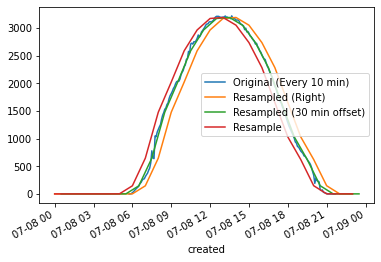

In [10]:
time_day = '2020-07-08'

series_pwr.sort_index().loc[time_day:time_day].plot(label='Original (Every 10 min)')
series_pwr_resampled_right.loc[time_day:time_day].plot(label='Resampled (Right)')
series_pwr_resampled_offset.loc[time_day:time_day].plot(label='Resampled (30 min offset)')

series_pwr_resampled.loc[time_day:time_day].plot(label='Resample')
plt.legend()

`Resampled (30 min offset)` is the resampling strategy that better overlaps with the original dataset.

## Read Weather History

We now read the weather data history and clean it, similarly to what done for the PV production data

In [11]:
all_files = sorted(glob.glob("data/history_weather_*.csv"))

li = []

for filename in all_files:
    df_part = pd.read_csv(filename, index_col=None, header=0)
    li.append(df_part)

df_wtr = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_wtr['created'] = pd.to_datetime(df_wtr['date'] + ' ' + df_wtr['time'], format='%d-%m-%Y %H:%M')
df_wtr.drop(['date', 'time'], axis=1, inplace=True)
df_wtr.set_index('created', drop=True, append=False, inplace=True)

In [13]:
df_wtr.head()

,cond,temp,wind,hr,press
created,,,,,
2019-10-05 00:20:00,Sereno,12,9,82,1010
2019-10-05 00:50:00,Sereno,11,6,87,1010
2019-10-05 01:20:00,Sereno,11,4,87,1009
2019-10-05 01:50:00,Sereno,11,6,82,1009
2019-10-05 02:20:00,Sereno,11,6,82,1010


In [14]:
df_wtr.applymap(np.isreal).all(0)

cond     False
temp     False
wind     False
hr       False
press     True
dtype: bool

Below is an example of data sample to be improved (`N/D` fields)

In [15]:
df_wtr.iloc[727]

cond     Prevalentemente coperto
temp                         N/D
wind                          15
hr                           N/D
press                       1017
Name: 2019-10-20 05:50:00, dtype: object

`N/D` values are replaced with `np.NaN` and *temp* and *hr* are interpolated from surrounding values.

In [16]:
df_wtr.replace('N/D', np.NaN, inplace=True)
df_wtr['temp'].interpolate(inplace=True)
df_wtr['hr'].interpolate(inplace=True)

df_wtr['wind'].replace('Calma', '0', inplace=True)
df_wtr["temp"] = pd.to_numeric(df_wtr["temp"])
df_wtr["hr"] = pd.to_numeric(df_wtr["hr"])

*Wind*: it contains strings, such as:
  -  `Calma`, to be replaced with integer `0`;
  -  `16 > 44`, replaced with the average of the two values.

The column is then dropped and replaced by `wind_avg`.

In [17]:
#df_wtr[df_wtr['wind_avg'].str.contains(">")]

wind_low = df_wtr[df_wtr['wind'].str.contains(">")]['wind'].str[:2].astype(int)
wind_upp = df_wtr[df_wtr['wind'].str.contains(">")]['wind'].str[-2:].astype(int)
df_wtr.loc[df_wtr['wind'].str.contains(">"), 'wind_avg'] = (wind_low + wind_upp) / 2.0

In [18]:
df_wtr.loc[~df_wtr['wind'].str.contains(">"), 'wind_avg'] = df_wtr[~df_wtr['wind'].str.contains(">")]['wind'].str[-2:].astype(float)

In [19]:
df_wtr.drop('wind', axis=1, inplace=True)

In [20]:
df_wtr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 33735 entries, 2019-10-05 00:20:00 to 2021-09-17 21:20:00
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cond      33735 non-null  object 
 1   temp      33734 non-null  float64
 2   hr        33734 non-null  float64
 3   press     33735 non-null  int64  
 4   wind_avg  33735 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.5+ MB


In [21]:
df_wtr['cond'].unique()

array(['Sereno', 'Nubi sparse', 'Parzialmente coperto',
       'Prevalentemente coperto', 'Cielo coperto', 'Pioggerellina',
       'Pioggia', 'Foschia', 'Pioggia debole', 'Tempesta', 'Nebbia',
       'Banchi di nebbia', 'Acquazzone nelle prossime ore',
       'Pioggia e neve', 'Nevicata debole', 'Nevicata', 'Gelata',
       'Vento e neve', 'Grani di neve'], dtype=object)

In [22]:
df_wtr_resampled = df_wtr.resample('H').mean().pad()
df_wtr_resampled.index = df_wtr_resampled.index + to_offset('30Min')

full_date_index = pd.date_range(start='2019-10-05 00:30:00', end='2021-09-17 23:30:00', freq='H')
full_date_wtr = df_wtr_resampled.reindex(full_date_index).fillna(0)


In [23]:
full_date_wtr

,temp,hr,press,wind_avg
2019-10-05 00:30:00,11.5,84.5,1010.0,7.5
2019-10-05 01:30:00,11.0,84.5,1009.0,5.0
2019-10-05 02:30:00,10.5,84.5,1009.5,6.0
2019-10-05 03:30:00,9.5,90.0,1009.0,7.0
2019-10-05 04:30:00,9.5,87.0,1008.5,6.5
...,...,...,...,...
2021-09-17 19:30:00,22.5,71.0,1010.0,8.0
2021-09-17 20:30:00,20.5,80.5,1011.0,6.0
2021-09-17 21:30:00,19.0,88.0,1011.0,9.0
2021-09-17 22:30:00,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='created'>

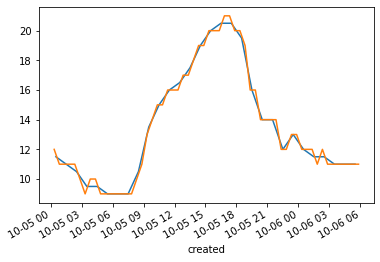

In [24]:
df_wtr_resampled.iloc[:30]['temp'].plot()
df_wtr.iloc[:60]['temp'].plot()

2021-10-27 13:41:28.368832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-27 13:41:28.368867: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-27 13:41:28.368889: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (davide-ThinkPad-T14s-Gen-1): /proc/driver/nvidia/version does not exist
2021-10-27 13:41:28.370219: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


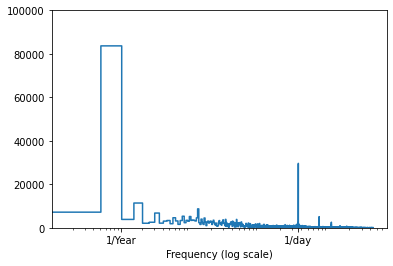

In [25]:
fft = tf.signal.rfft(full_date_wtr['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(full_date_wtr['temp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Merge the two datasets on time index

In [26]:
df_wtr_resampled.index.min(), df_wtr_resampled.index.max()
series_pwr_resampled_offset.index.min(), series_pwr_resampled_offset.index.max()

(Timestamp('2019-10-04 19:30:00', freq='H'),
 Timestamp('2021-09-19 19:30:00', freq='H'))

In [27]:
series_pwr_resampled_offset = series_pwr_resampled_offset.truncate(before=pd.Timestamp('2019-10-05 00:30:00'), after=pd.Timestamp('2021-09-17 21:30:00'))

In [28]:
series_pwr_resampled_offset.index.min(), series_pwr_resampled_offset.index.max()

(Timestamp('2019-10-05 00:30:00', freq='H'),
 Timestamp('2021-09-17 21:30:00', freq='H'))

In [29]:
df_wtr_resampled = df_wtr_resampled[(df_wtr_resampled.index.hour > 4) & (df_wtr_resampled.index.hour < 22)]

In [30]:
df_wtr_resampled.head(20)

,temp,hr,press,wind_avg
created,,,,
2019-10-05 05:30:00,9.0,87.0,1008.0,7.0
2019-10-05 06:30:00,9.0,87.0,1009.0,8.0
2019-10-05 07:30:00,9.0,87.0,1009.0,9.0
2019-10-05 08:30:00,10.5,87.0,1009.5,8.0
2019-10-05 09:30:00,13.5,74.5,1010.0,4.0
2019-10-05 10:30:00,15.0,67.0,1010.0,6.0
2019-10-05 11:30:00,16.0,63.0,1010.0,6.5
2019-10-05 12:30:00,16.5,63.0,1010.0,6.0
2019-10-05 13:30:00,17.5,57.5,1009.5,6.0


In [31]:
series_pwr_resampled_offset = series_pwr_resampled_offset[(series_pwr_resampled_offset.index.hour > 4) & (series_pwr_resampled_offset.index.hour < 22)]

In [32]:
series_pwr_resampled_offset.shape
df_wtr_resampled.shape
df_merged = df_wtr_resampled.merge(series_pwr_resampled_offset.to_frame(), left_index=True, right_index=True)

In [33]:
df_merged['hour'] = df_merged.index.hour
df_merged['month'] = df_merged.index.month

## Prepare the dataset for training



### Clustering

As shown, the number of reported weather conditions is too high for such a small dataset. An effort aimed at reducing the number of features is done.

In [34]:
arr_merged = df_merged.to_numpy()

In [35]:
scaler = preprocessing.StandardScaler().fit(arr_merged)
scaler.mean_

array([  14.63923216,   68.38585434, 1015.80309771,    7.57781348,
        778.17106391,   13.        ,    6.45518207])

In [36]:
arr_merged_scaled = scaler.transform(arr_merged)

In [37]:
series_cond = df_wtr[(df_wtr.index.minute == 20) & (df_wtr.index.hour > 4) & (df_wtr.index.hour < 22)]['cond']
full_series_cond = df_wtr[df_wtr.index.minute == 20]['cond']

series_cond.truncate(before=pd.Timestamp('2019-10-05 00:00:00'), after=pd.Timestamp('2021-09-18 00:00:00'))

created
2019-10-05 05:20:00         Sereno
2019-10-05 06:20:00         Sereno
2019-10-05 07:20:00    Nubi sparse
2019-10-05 08:20:00    Nubi sparse
2019-10-05 09:20:00    Nubi sparse
                          ...     
2021-09-17 17:20:00         Sereno
2021-09-17 18:20:00         Sereno
2021-09-17 19:20:00         Sereno
2021-09-17 20:20:00         Sereno
2021-09-17 21:20:00         Sereno
Name: cond, Length: 11956, dtype: object

In [38]:
series_cond.index = series_cond.index + to_offset('10Min')
full_series_cond.index = full_series_cond.index + to_offset('10Min')

series_cond

created
2019-10-05 05:30:00         Sereno
2019-10-05 06:30:00         Sereno
2019-10-05 07:30:00    Nubi sparse
2019-10-05 08:30:00    Nubi sparse
2019-10-05 09:30:00    Nubi sparse
                          ...     
2021-09-17 17:30:00         Sereno
2021-09-17 18:30:00         Sereno
2021-09-17 19:30:00         Sereno
2021-09-17 20:30:00         Sereno
2021-09-17 21:30:00         Sereno
Name: cond, Length: 11956, dtype: object

In [39]:
benchmark = pd.date_range(start='2019-10-05 00:30', end='2021-09-17 23:30', freq='1H')
benchmark = benchmark[(benchmark.hour > 4) & (benchmark.hour < 22)]

missing_idxs = benchmark.difference(series_cond.index)

series_cond = pd.Series(data=series_cond, index=benchmark)
series_cond.loc[missing_idxs] = 'Unknown'

series_cond[series_cond == 'Unknown']

2019-11-22 10:30:00    Unknown
2019-11-26 05:30:00    Unknown
2019-11-26 06:30:00    Unknown
2019-11-28 05:30:00    Unknown
2019-12-01 06:30:00    Unknown
                        ...   
2021-08-22 17:30:00    Unknown
2021-09-12 15:30:00    Unknown
2021-09-12 16:30:00    Unknown
2021-09-12 17:30:00    Unknown
2021-09-12 18:30:00    Unknown
Name: cond, Length: 182, dtype: object

In [40]:
strings_cond = set(series_cond)
index_cond = range(len(strings_cond))
dict_cond = dict(zip(strings_cond, index_cond))

strings_cond_series = series_cond.apply(lambda x: dict_cond[x])

In [41]:
strings_cond_series

2019-10-05 05:30:00    16
2019-10-05 06:30:00    16
2019-10-05 07:30:00     4
2019-10-05 08:30:00     4
2019-10-05 09:30:00     4
                       ..
2021-09-17 17:30:00    16
2021-09-17 18:30:00    16
2021-09-17 19:30:00    16
2021-09-17 20:30:00    16
2021-09-17 21:30:00    16
Name: cond, Length: 12138, dtype: int64

In [42]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(arr_merged_scaled)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_one = pca_result[:,0]
pca_two = pca_result[:,1] 
pca_three = pca_result[:,2] 

Explained variation per principal component: [0.3237686  0.18949236 0.16202608]


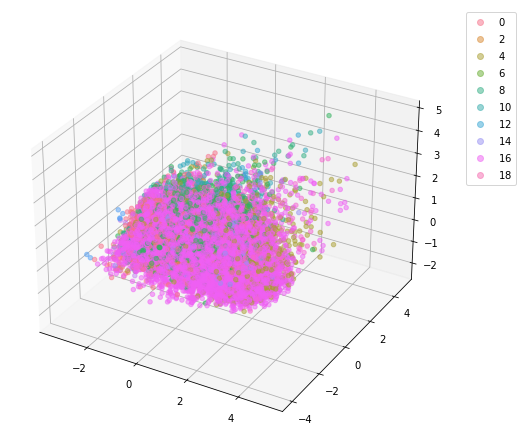

In [43]:
# # axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# # get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", len(index_cond)).as_hex())

# # plot
sc = ax.scatter(pca_one, pca_two, pca_three, c=strings_cond_series, cmap=cmap, alpha=.5)

# # legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

In [44]:
transform_dict = {'Sereno': 'sunny', 
                  'Nubi sparse': 'sunny', 
                  'Parzialmente coperto': 'cloudy',
                  'Prevalentemente coperto': 'cloudy', 
                  'Cielo coperto': 'cloudy', 
                  'Pioggerellina': 'rainy',
                  'Pioggia': 'rainy', 
                  'Foschia': 'fog', 
                  'Pioggia debole': 'rainy', 
                  'Tempesta': 'rainy', 
                  'Nebbia': 'fog',
                  'Banchi di nebbia': 'fog', 
                  'Acquazzone nelle prossime ore': 'unknown',
                  'Pioggia e neve': 'snow', 
                  'Nevicata debole': 'snow', 
                  'Nevicata': 'snow', 
                  'Gelata': 'unknown',
                  'Vento e neve': 'snow', 
                  'Grani di neve': 'snow', 
                  'Unknown': 'unknown'}
series_cond = series_cond.transform(lambda x: transform_dict[x])

In [45]:
df_merged.describe()

,temp,hr,press,wind_avg,grid_power,hour,month
count,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000,12138.000000
mean,14.639232,68.385854,1015.803098,7.577813,778.171064,13.000000,6.455182
std,8.160135,20.225159,8.010107,4.105549,931.460325,4.899181,3.464055
min,-5.000000,8.000000,984.500000,0.000000,0.000000,5.000000,1.000000
25%,8.000000,52.500000,1011.000000,5.000000,3.875000,9.000000,3.000000
50%,14.000000,69.000000,1016.000000,6.500000,335.375000,13.000000,6.000000
75%,21.000000,86.000000,1021.000000,9.000000,1374.812500,17.000000,10.000000
max,33.500000,100.000000,1044.000000,48.750000,3601.083333,21.000000,12.000000


In [46]:
df_final = df_merged.merge(pd.get_dummies(series_cond), left_index=True, right_index=True) # one-hot enconding
df_final = df_final.drop(columns=['hour'])

In [47]:
df_final.head()

,temp,hr,press,wind_avg,grid_power,month,cloudy,fog,rainy,snow,sunny,unknown
created,,,,,,,,,,,,
2019-10-05 05:30:00,9.0,87.0,1008.0,7.0,0.000000,10,0,0,0,0,1,0
2019-10-05 06:30:00,9.0,87.0,1009.0,8.0,0.000000,10,0,0,0,0,1,0
2019-10-05 07:30:00,9.0,87.0,1009.0,9.0,41.666667,10,0,0,0,0,1,0
2019-10-05 08:30:00,10.5,87.0,1009.5,8.0,731.166667,10,0,0,0,0,1,0
2019-10-05 09:30:00,13.5,74.5,1010.0,4.0,1304.666667,10,0,0,0,0,1,0


In [48]:
round(df_final.describe(), 2).transpose()

,count,mean,std,min,25%,50%,75%,max
temp,12138.0,14.64,8.16,-5.0,8.00,14.00,21.00,33.50
hr,12138.0,68.39,20.23,8.0,52.50,69.00,86.00,100.00
press,12138.0,1015.80,8.01,984.5,1011.00,1016.00,1021.00,1044.00
wind_avg,12138.0,7.58,4.11,0.0,5.00,6.50,9.00,48.75
grid_power,12138.0,778.17,931.46,0.0,3.88,335.38,1374.81,3601.08
month,12138.0,6.46,3.46,1.0,3.00,6.00,10.00,12.00
cloudy,12138.0,0.30,0.46,0.0,0.00,0.00,1.00,1.00
fog,12138.0,0.08,0.27,0.0,0.00,0.00,0.00,1.00
rainy,12138.0,0.09,0.29,0.0,0.00,0.00,0.00,1.00
snow,12138.0,0.00,0.06,0.0,0.00,0.00,0.00,1.00


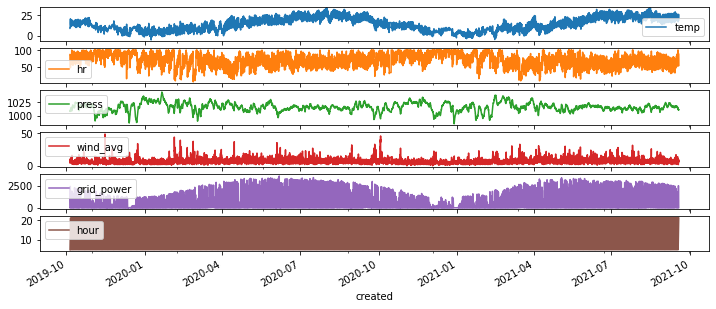

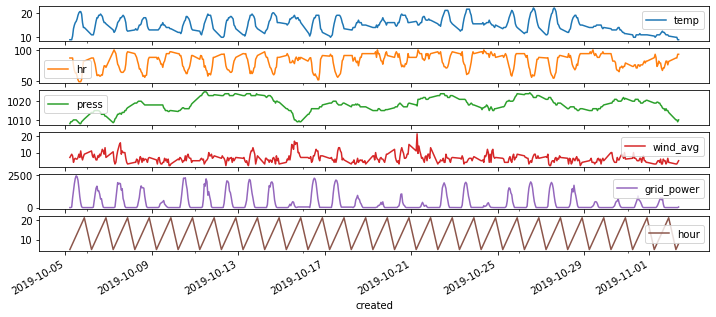

In [49]:
df_final['hour'] = df_final.index.hour
plot_cols = ['temp', 'hr', 'press', 'wind_avg', 'grid_power', 'hour']
plot_features = df_final[plot_cols]
_ = plot_features.plot(subplots=True, figsize=(12, 5))

plot_features = df_final[plot_cols][:480]
_ = plot_features.plot(subplots=True, figsize=(12, 5))


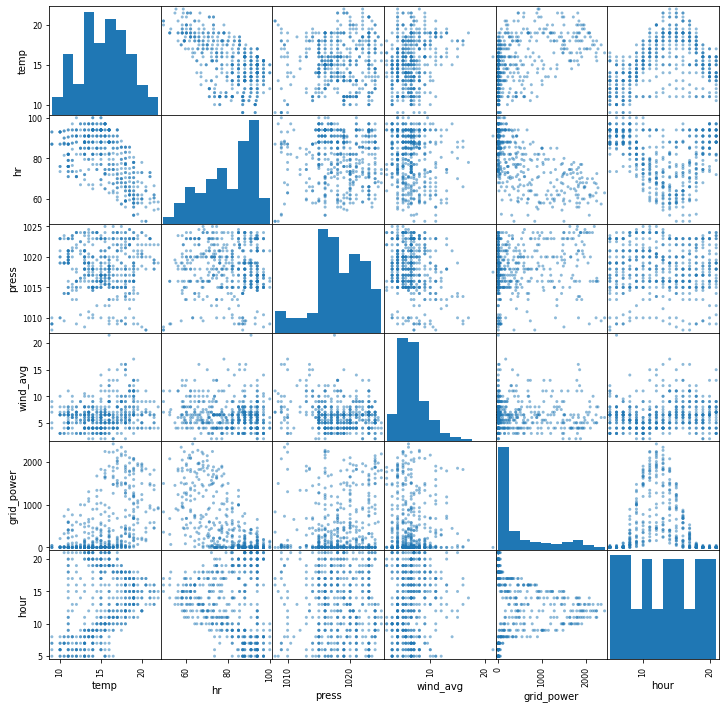

In [50]:
_ = pd.plotting.scatter_matrix(plot_features, figsize=(12,12))
df_final.drop('hour', axis=1, inplace=True)

Text(0.5, 1.0, 'Time of year signal')

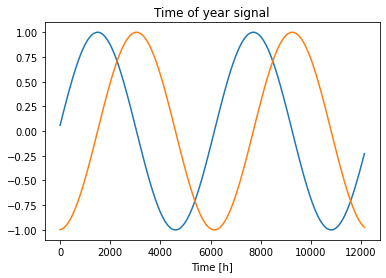

In [51]:
timestamp_s = df_final.index.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

day_sin = np.sin(timestamp_s * (2 * np.pi / day))
day_cos = np.cos(timestamp_s * (2 * np.pi / day))
year_sin = np.sin(timestamp_s * (2 * np.pi / year))
year_cos = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(year_cos))
plt.plot(np.array(year_sin))
plt.xlabel('Time [h]')
plt.title('Time of year signal')


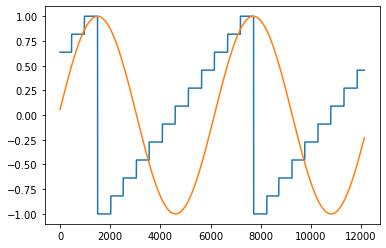

In [52]:
plt.plot(((df_final['month'] - 6.5) / 5.5).to_numpy(), label='Months')
plt.plot(np.array(year_cos), label='Year Period')

In [53]:
df_final['month'] = year_cos

### Scale the data

In [54]:
scaler_lstm = preprocessing.StandardScaler()
# scaler_lstm = preprocessing.StandardScaler()
scaled_features = scaler_lstm.fit_transform(df_final[['temp', 'hr', 'press', 'wind_avg', 'grid_power', 'month']])

In [55]:
df = pd.DataFrame(np.concatenate((scaled_features, df_final[['cloudy', 'fog', 'rainy', 'snow',	'sunny', 'unknown']].to_numpy()), axis=1), 
                  index=df_final.index, columns=df_final.columns)
df.head()

,temp,hr,press,wind_avg,grid_power,month,cloudy,fog,rainy,snow,sunny,unknown
created,,,,,,,,,,,,
2019-10-05 05:30:00,-0.691099,0.920384,-0.974197,-0.140745,-0.835466,0.079351,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 06:30:00,-0.691099,0.920384,-0.849349,0.102837,-0.835466,0.080352,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 07:30:00,-0.691099,0.920384,-0.849349,0.346420,-0.790731,0.081352,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 08:30:00,-0.507271,0.920384,-0.786926,0.102837,-0.050465,0.082353,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 09:30:00,-0.139615,0.302316,-0.724502,-0.871494,0.565260,0.083354,0.0,0.0,0.0,0.0,1.0,0.0


### Split the data into Training, Validation and Test

In [56]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [57]:
df.shape

(12138, 12)

## 1-day Time Window Forecast

In [58]:
MAX_EPOCHS = 50
BATCH_SIZE = 16

def compile_and_fit(model, window, model_name, patience=3):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + f'_ep{MAX_EPOCHS}_bs{BATCH_SIZE}_{model_name}')
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[tensorboard_callback, early_stopping])
  return history

In [59]:
val_performance = {}
train_performance = {}
performance = {}


### Window Generator

In [60]:
class WindowGenerator():

  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.test))
      # And cache it for next time
      self._example = result
    return result

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    return ds

  def plot(self, model=None, plot_col='grid_power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [61]:
OUT_STEPS = 17

one_day_window = WindowGenerator(
    input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['grid_power']
    )
    
for example_inputs, example_labels in one_day_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 17, 12)
Labels shape (batch, time, features): (16, 17, 1)


2021-10-27 13:41:35.515580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [62]:
one_day_window.train.element_spec

(TensorSpec(shape=(None, 17, 12), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 17, 1), dtype=tf.float32, name=None))

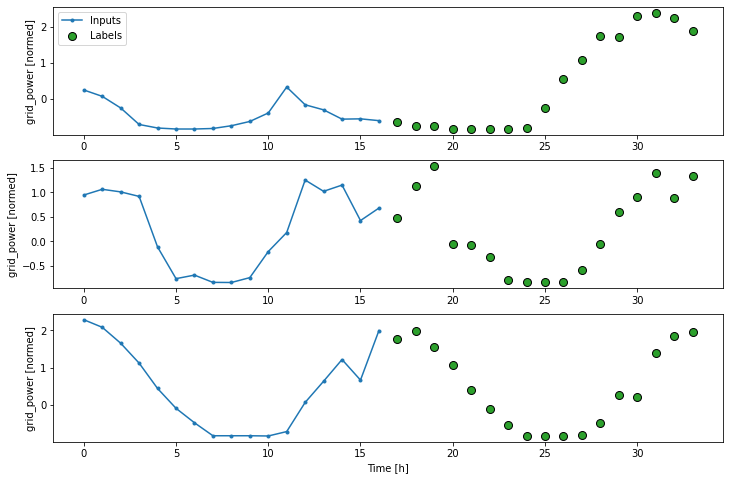

In [63]:
one_day_window.plot() # plots an example

### Baseline Model (Repeat Input Sample)

529/529 [==============================] - 1s 1ms/step - loss: 0.2940 - mean_absolute_error: 0.2662


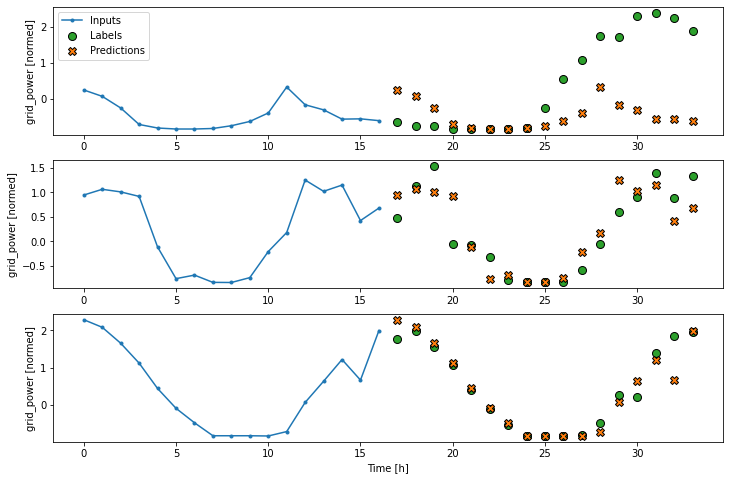

In [64]:
class RepeatBaseline(tf.keras.Model):

  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    return tf.expand_dims(inputs[:, :, self.label_index], axis=-1)

    
repeat_baseline = RepeatBaseline(label_index=column_indices['grid_power'])
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

val_performance['Repeat Prev Day'] = repeat_baseline.evaluate(one_day_window.val)
train_performance['Repeat Prev Day'] = repeat_baseline.evaluate(one_day_window.train)
performance['Repeat Prev Day'] = repeat_baseline.evaluate(one_day_window.test, verbose=0)
one_day_window.plot(repeat_baseline)


### Single-Shot Linear Model

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 12)             0         
_________________________________________________________________
dense (Dense)                (None, 1, 17)             221       
_________________________________________________________________
reshape (Reshape)            (None, 17, 1)             0         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
150/150 [==============================] - 0s 1ms/step - loss: 0.5570 - mean_absolute_error: 0.5904


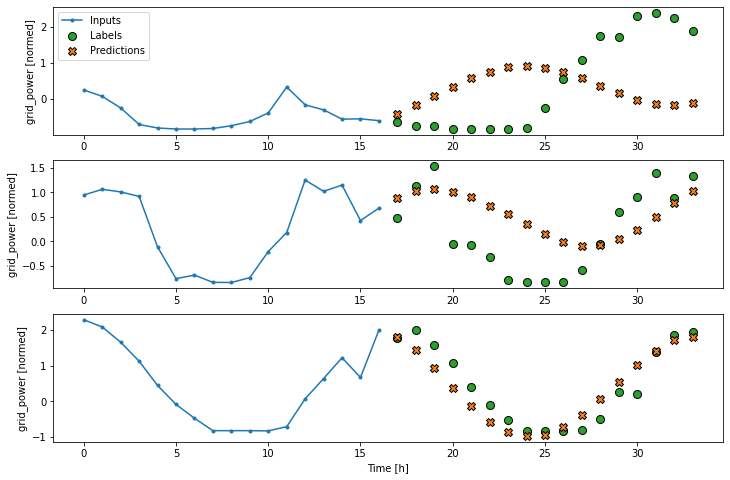

In [65]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_linear_model, one_day_window, 'linear_one-day_history')

IPython.display.clear_output()
multi_linear_model.summary()
train_performance['Linear'] = multi_linear_model.evaluate(one_day_window.train)
val_performance['Linear'] = multi_linear_model.evaluate(one_day_window.val)
performance['Linear'] = multi_linear_model.evaluate(one_day_window.test, verbose=0)
one_day_window.plot(multi_linear_model)

### Single-Shot Dense Model

Adding a tf.keras.layers.Dense between the input and output gives the linear model more power, but is still only based on a single input time step.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 12)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 128)            1664      
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 17)             2193      
_________________________________________________________________
reshape_1 (Reshape)          (None, 17, 1)             0         
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________
150/150 [==============================] - 0s 1ms/step - loss: 0.5128 - mean_absolute_error: 0.5375


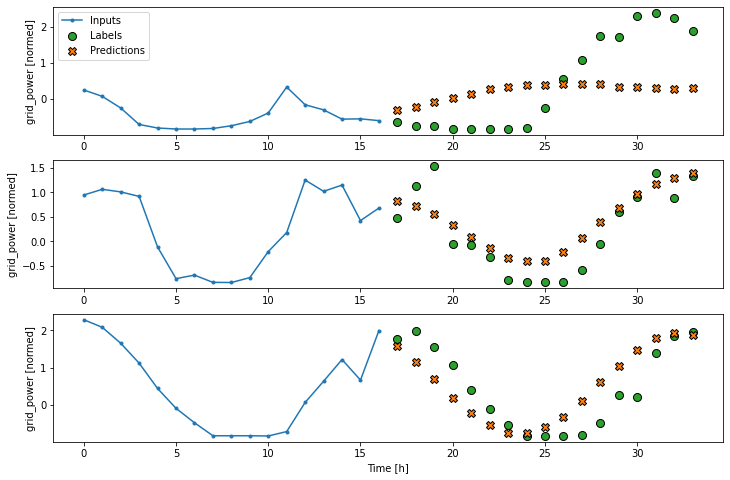

In [66]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :], input_shape=(17, 12)),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])


history = compile_and_fit(multi_dense_model, one_day_window, 'dense_one-day_history')

IPython.display.clear_output()
multi_dense_model.summary()
train_performance['Dense'] = multi_dense_model.evaluate(one_day_window.train)
val_performance['Dense'] = multi_dense_model.evaluate(one_day_window.val)
performance['Dense'] = multi_dense_model.evaluate(one_day_window.test, verbose=0)
one_day_window.plot(multi_dense_model)

### Single-Shot CNN

150/150 [==============================] - 0s 1ms/step - loss: 0.3786 - mean_absolute_error: 0.4255


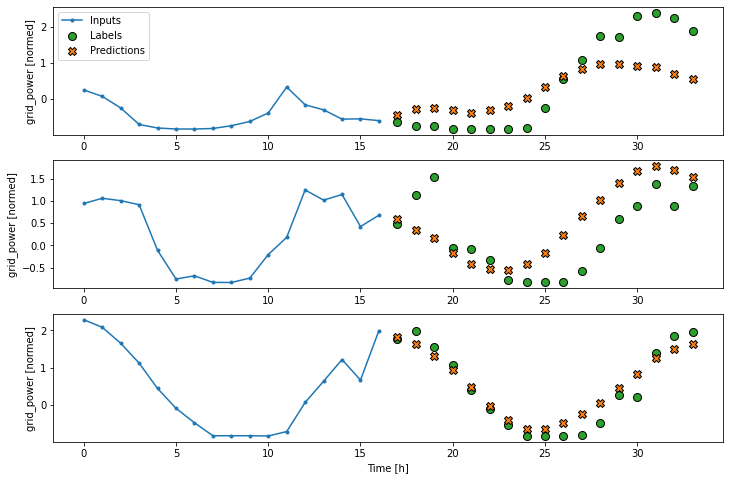

In [67]:
CONV_WIDTH = 3

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :], input_shape=(17, 12)),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

multi_conv_model.summary()

history = compile_and_fit(multi_conv_model, one_day_window, 'CNN_one-day_history')

IPython.display.clear_output()

train_performance['Conv'] = multi_conv_model.evaluate(one_day_window.train)
val_performance['Conv'] = multi_conv_model.evaluate(one_day_window.val)
performance['Conv'] = multi_conv_model.evaluate(one_day_window.test, verbose=0)
one_day_window.plot(multi_conv_model)


### Single-Shot LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                12600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 17)                867       
_________________________________________________________________
reshape_3 (Reshape)          (None, 17, 1)             0         
Total params: 13,467
Trainable params: 13,467
Non-trainable params: 0
_________________________________________________________________
150/150 [==============================] - 1s 4ms/step - loss: 0.2779 - mean_absolute_error: 0.3367


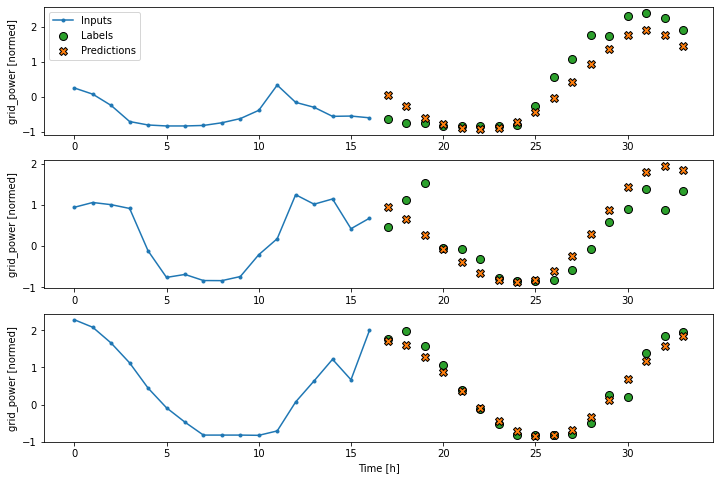

In [68]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(17, 12)),
    tf.keras.layers.Dropout(0.25),
    # tf.keras.layers.LSTM(8, return_sequences=True),
    # tf.keras.layers.Dropout(0.25),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(OUT_STEPS),
    # tf.keras.layers.Dense(1)
    # ), # kernel_initializer=tf.initializers.zeros(), 
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, one_day_window, 'LSTM_one-day_history_LSTM')

IPython.display.clear_output()
multi_lstm_model.summary()

train_performance['LSTM 1-day'] = multi_lstm_model.evaluate(one_day_window.train)
val_performance['LSTM 1-day'] = multi_lstm_model.evaluate(one_day_window.val)
performance['LSTM 1-day'] = multi_lstm_model.evaluate(one_day_window.test, verbose=0)
one_day_window.plot(multi_lstm_model)


### 1-day Results

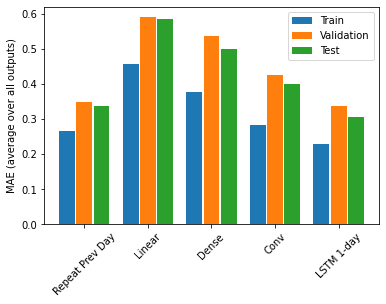

In [69]:
x = np.arange(len(performance))
width = 0.25

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in train_performance.values()]
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.27, train_mae, width, label='Train')
plt.bar(x, val_mae, width, label='Validation')
plt.bar(x + 0.27, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [70]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Repeat Prev Day: 0.3378
Linear         : 0.5851
Dense          : 0.4996
Conv           : 0.3992
LSTM 1-day     : 0.3048


## 2-day Time Window Forecast

In [71]:
OUT_STEPS = 17

two_day_window = WindowGenerator(
    input_width=34, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['grid_power']
    )
    
for example_inputs, example_labels in one_day_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (16, 17, 12)
Labels shape (batch, time, features): (16, 17, 1)


### Baseline Model (Repeat Input Sample)

149/149 [==============================] - 0s 1ms/step - loss: 0.3603 - mean_absolute_error: 0.3479


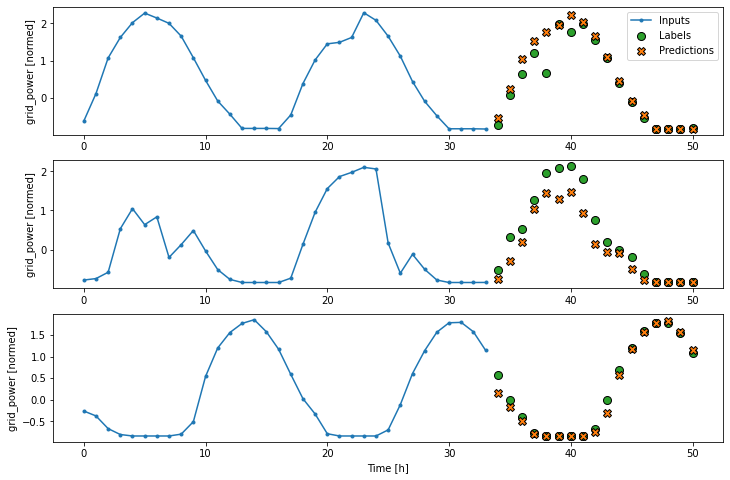

In [72]:
class TwoDayRepeatBaseline(tf.keras.Model):
    """
    Return average from previous two days
    """

    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        days = tf.split(inputs[:, :, self.label_index], 2, axis=1)
        return tf.expand_dims(tf.reduce_mean(tf.stack(days), axis=0), axis=-1)

repeat_baseline = TwoDayRepeatBaseline(label_index=column_indices['grid_power'])
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

train_performance['Repeat 2-day Avg'] = repeat_baseline.evaluate(two_day_window.train)
val_performance['Repeat 2-day Avg'] = repeat_baseline.evaluate(two_day_window.val)
performance['Repeat 2-day Avg'] = repeat_baseline.evaluate(two_day_window.test, verbose=0)
two_day_window.plot(repeat_baseline)

### Single-Shot LSTM

149/149 [==============================] - 1s 5ms/step - loss: 0.3176 - mean_absolute_error: 0.3503


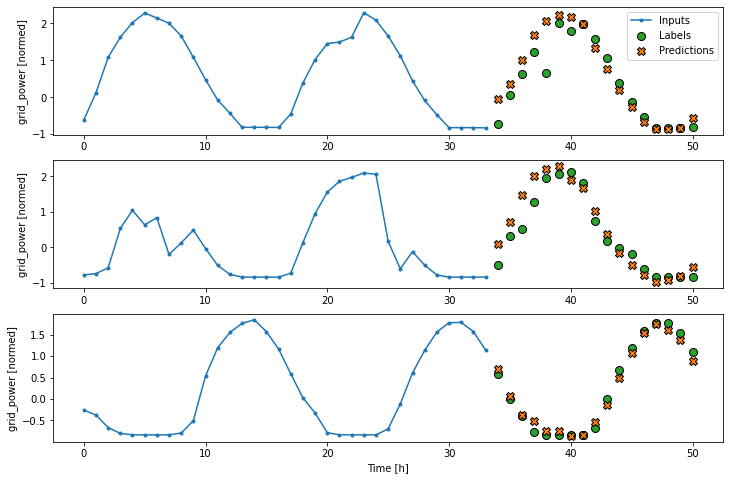

In [73]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(34, 12)),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

multi_lstm_model.summary()
history = compile_and_fit(multi_lstm_model, two_day_window, 'LSTM_two-day_history')

IPython.display.clear_output()

train_performance['LSTM 2-day'] = multi_lstm_model.evaluate(two_day_window.train)
val_performance['LSTM 2-day'] = multi_lstm_model.evaluate(two_day_window.val)
performance['LSTM 2-day'] = multi_lstm_model.evaluate(two_day_window.test, verbose=0)
two_day_window.plot(multi_lstm_model)


### Single-Shot LSTM Return Sequences

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 34, 50)            12600     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 50)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 34, 1)             51        
_________________________________________________________________
flatten (Flatten)            (None, 34)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 17)                595       
_________________________________________________________________
reshape_5 (Reshape)          (None, 17, 1)             0         
Total params: 13,246
Trainable params: 13,246
Non-trainable params: 0
__________________________________________________

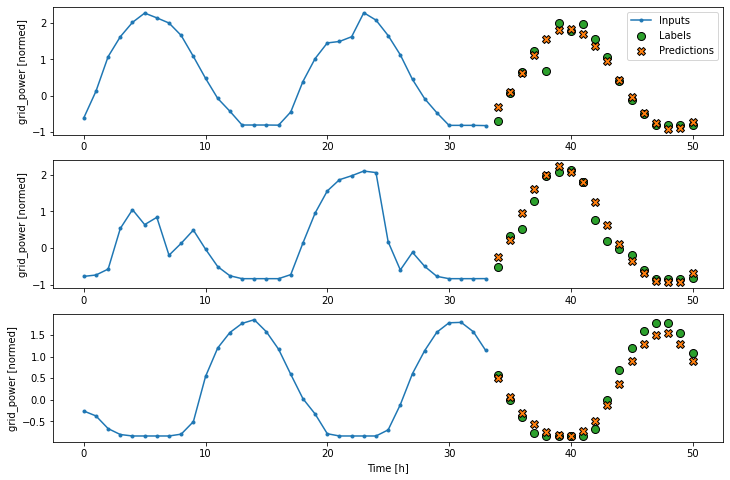

In [74]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(34, 12)),
    tf.keras.layers.Dropout(0.25),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(OUT_STEPS),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, two_day_window, 'LSTM-seq_two-day_history_17u')

IPython.display.clear_output()
multi_lstm_model.summary()

train_performance['LSTM Seq 2-day'] = multi_lstm_model.evaluate(two_day_window.train)
val_performance['LSTM Seq 2-day'] = multi_lstm_model.evaluate(two_day_window.val)
performance['LSTM Seq 2-day'] = multi_lstm_model.evaluate(two_day_window.test, verbose=0)
two_day_window.plot(multi_lstm_model)


### 2-day Results

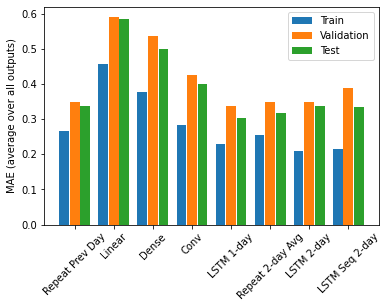

In [75]:
x = np.arange(len(performance))
width = 0.25

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in train_performance.values()]
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.27, train_mae, width, label='Train')
plt.bar(x, val_mae, width, label='Validation')
plt.bar(x + 0.27, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


## Weather forecast as prediction

In [76]:
df_forecasts = df.copy()
df_forecasts['grid_power'] = df_forecasts['grid_power'].shift(17)
df_forecasts.rename(columns={'grid_power': 'grid_power_day_minus1'}, inplace=True)
# df_forecasts.drop('grid_power', axis=1, inplace=True)
df_forecasts.head(34)

,temp,hr,press,wind_avg,grid_power_day_minus1,month,cloudy,fog,rainy,snow,sunny,unknown
created,,,,,,,,,,,,
2019-10-05 05:30:00,-0.691099,0.920384,-0.974197,-0.140745,NaN,0.079351,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 06:30:00,-0.691099,0.920384,-0.849349,0.102837,NaN,0.080352,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 07:30:00,-0.691099,0.920384,-0.849349,0.346420,NaN,0.081352,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 08:30:00,-0.507271,0.920384,-0.786926,0.102837,NaN,0.082353,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 09:30:00,-0.139615,0.302316,-0.724502,-0.871494,NaN,0.083354,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 10:30:00,0.044213,-0.068524,-0.724502,-0.384328,NaN,0.084354,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 11:30:00,0.166765,-0.266306,-0.724502,-0.262537,NaN,0.085355,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 12:30:00,0.228041,-0.266306,-0.724502,-0.384328,NaN,0.086355,0.0,0.0,0.0,0.0,1.0,0.0
2019-10-05 13:30:00,0.350593,-0.538255,-0.786926,-0.384328,NaN,0.087356,0.0,0.0,0.0,0.0,1.0,0.0


In [77]:
df_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12138 entries, 2019-10-05 05:30:00 to 2021-09-17 21:30:00
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temp                   12138 non-null  float64
 1   hr                     12138 non-null  float64
 2   press                  12138 non-null  float64
 3   wind_avg               12138 non-null  float64
 4   grid_power_day_minus1  12121 non-null  float64
 5   month                  12138 non-null  float64
 6   cloudy                 12138 non-null  float64
 7   fog                    12138 non-null  float64
 8   rainy                  12138 non-null  float64
 9   snow                   12138 non-null  float64
 10  sunny                  12138 non-null  float64
 11  unknown                12138 non-null  float64
dtypes: float64(12)
memory usage: 1.5 MB


In [78]:
df_forecasts.dropna(axis=0, inplace=True)

In [79]:
OUT_STEPS = 17

column_indices = {name: i for i, name in enumerate(df_forecasts.columns)}

n = len(df_forecasts)
train_df = df_forecasts[0:int(n*0.7)]
val_df = df_forecasts[int(n*0.7):int(n*0.9)]
test_df = df_forecasts[int(n*0.9):]

one_day_window = WindowGenerator(
    input_width=17, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['grid_power_day_minus1'], train_df=train_df, test_df=test_df, val_df=val_df
    )

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                12600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 17)                867       
_________________________________________________________________
reshape_14 (Reshape)         (None, 17, 1)             0         
Total params: 13,467
Trainable params: 13,467
Non-trainable params: 0
_________________________________________________________________
150/150 [==============================] - 1s 4ms/step - loss: 0.1275 - mean_absolute_error: 0.2298


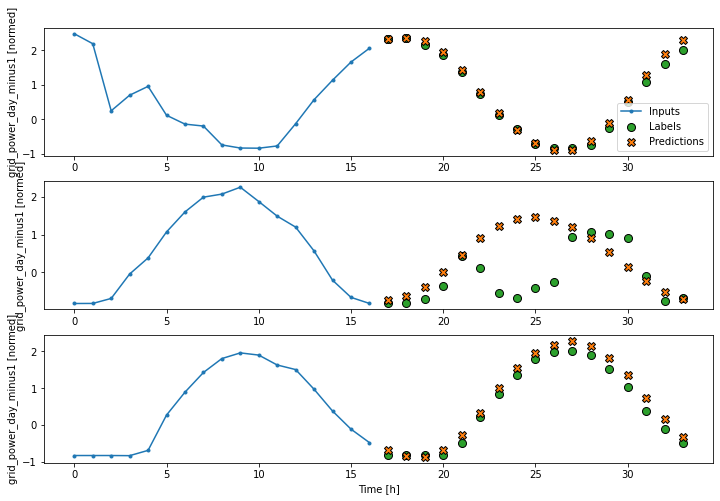

In [88]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(17, 12)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(OUT_STEPS),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, one_day_window, 'LSTM-seq_one-day_forecast_50')

IPython.display.clear_output()
multi_lstm_model.summary()

train_performance['LSTM Forecast'] = multi_lstm_model.evaluate(one_day_window.train)
val_performance['LSTM Forecast'] = multi_lstm_model.evaluate(one_day_window.val)
performance['LSTM Forecast'] = multi_lstm_model.evaluate(one_day_window.test, verbose=0)

one_day_window.plot(multi_lstm_model, plot_col='grid_power_day_minus1')

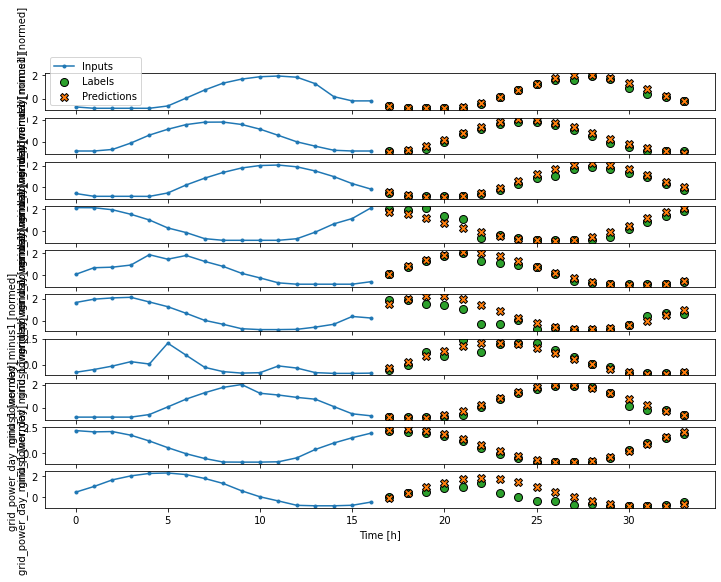

In [81]:
one_day_window.plot(multi_lstm_model, plot_col='grid_power_day_minus1', max_subplots=10)

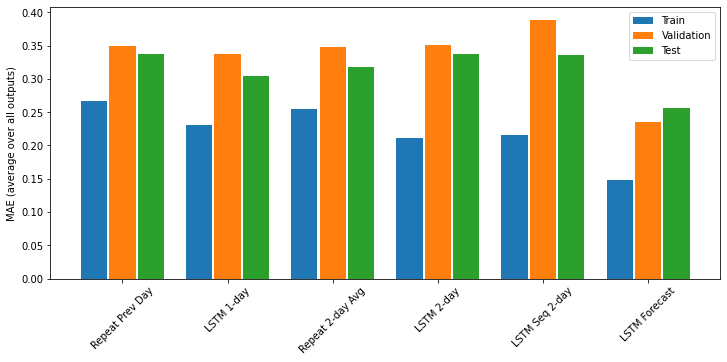

In [83]:
for perf in [train_performance, val_performance, performance]:
    del perf['Dense']
    del perf['Linear']
    del perf['Conv']

x = np.arange(len(performance))
width = 0.25

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in train_performance.values()]
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

fig, ax = plt.subplots(figsize=(12, 5))
plt.bar(x - 0.27, train_mae, width, label='Train')
plt.bar(x, val_mae, width, label='Validation')
plt.bar(x + 0.27, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
%load_ext tensorboard

## Cross Validation

![Caption](imgs/k_fold.png)

In [85]:
cross_train_performance = {}
cross_val_performance = {}
cross_test_performance = {}

OUT_STEPS = 17

column_indices = {name: i for i, name in enumerate(df_forecasts.columns)}
n = len(df_forecasts)

for ii in range(3, 8):
    train_df = df_forecasts[0:int(n*0.1*ii)]
    val_df = df_forecasts[int(n*0.1*ii):int(n*(0.1*ii+0.2))]
    test_df = df_forecasts[int(n*(0.1*ii+0.2)):int(n*(0.1*ii+0.3))]

    one_day_window = WindowGenerator(
        input_width=17, label_width=OUT_STEPS, shift=OUT_STEPS, label_columns=['grid_power_day_minus1'], train_df=train_df, test_df=test_df, val_df=val_df
        )

    multi_lstm_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=False, input_shape=(17, 12)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(OUT_STEPS),
        tf.keras.layers.Reshape([OUT_STEPS, 1])
    ])

    history = compile_and_fit(multi_lstm_model, one_day_window, 'LSTM-seq_one-day_forecast_50')

    cross_train_performance[f'{ii*10}-20-10'] = multi_lstm_model.evaluate(one_day_window.train)
    cross_val_performance[f'{ii*10}-20-10'] = multi_lstm_model.evaluate(one_day_window.val)
    cross_test_performance[f'{ii*10}-20-10'] = multi_lstm_model.evaluate(one_day_window.test, verbose=0)

    IPython.display.clear_output()


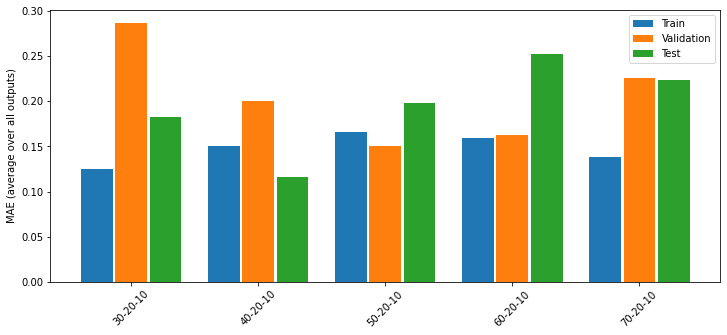

In [87]:
x = np.arange(len(cross_train_performance))
width = 0.25

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
train_mae = [v[metric_index] for v in cross_train_performance.values()]
val_mae = [v[metric_index] for v in cross_val_performance.values()]
test_mae = [v[metric_index] for v in cross_test_performance.values()]

fig = plt.figure(figsize=(12, 5))
plt.bar(x - 0.27, train_mae, width, label='Train')
plt.bar(x, val_mae, width, label='Validation')
plt.bar(x + 0.27, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=cross_train_performance.keys(), rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

## Inference on test dataset

In [89]:
test_days = test_df[6:].copy()

test_days.rename(columns={'grid_power_day_minus1': 'grid_power'}, inplace=True)

full_scale = scaler_lstm.inverse_transform(test_days[['temp', 'hr', 'press', 'wind_avg', 'grid_power', 'month']])

full_scale = pd.DataFrame(np.concatenate((full_scale, test_days[['cloudy', 'fog', 'rainy', 'snow', 'sunny', 'unknown']].to_numpy()), axis=1), 
                   index=test_days.index, columns=test_days.columns)

In [90]:
inputs = test_days[:-17].to_numpy()
inputs = np.reshape(inputs, (-1, 17, 12))

In [91]:
labels = full_scale['grid_power'][17:].to_numpy()
labels = np.reshape(labels, (-1, 17))

In [92]:
predictions = np.squeeze(multi_lstm_model.predict(inputs))
scaled_predictions = scaler_lstm.inverse_transform(np.tile(np.reshape(predictions, (1, -1)).T, (1, 6)))[:, 4]
scaled_predictions = np.reshape(scaled_predictions, (-1, 17))
scaled_predictions = scaled_predictions.clip(min=0)

In [93]:
mae = np.abs(scaled_predictions - labels)
predicted_day_production = np.sum(scaled_predictions, axis=1)
true_day_production = np.sum(labels, axis=1)
delta_production = true_day_production - predicted_day_production

Text(0, 0.5, 'Frequency [-]')

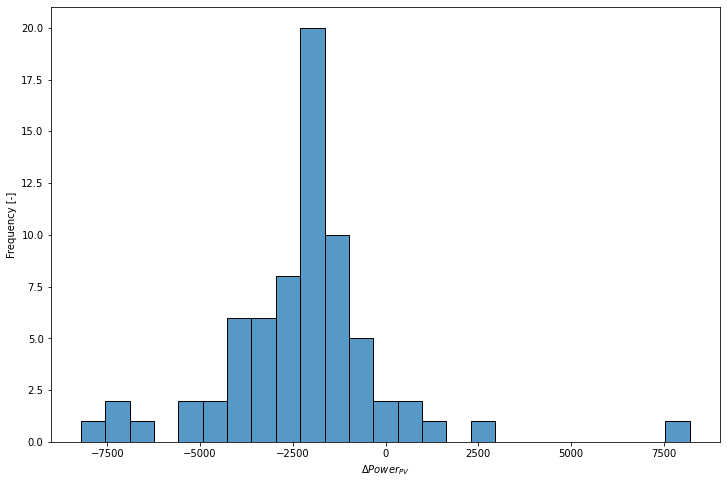

In [100]:
plt.figure(figsize=(12, 8))
ax = sns.histplot(x=delta_production, bins=25)
ax.set_xlabel(r'$\Delta{Power_{PV}}$')
ax.set_ylabel(r'Frequency [-]')

In [104]:
print(f'Average daily production is:     {round(true_day_production.mean()/1000, 1)} kWh')
print(f'Average error on predictions is: {round(delta_production.mean() / true_day_production.mean() * 100, 1)} %')

Average daily production is:     18.4 kWh
Average error on predictions is: -12.1 %


In [112]:
print(f'MAE [W] is: {mae.mean():.0f} W')
for i, mae_h in enumerate(mae.mean(axis=0)):
    print(f'{i+5:02}:00\t{mae_h:.0f} W')


MAE [W] is: 233 W
05:00	38 W
06:00	170 W
07:00	237 W
08:00	235 W
09:00	298 W
10:00	334 W
11:00	317 W
12:00	386 W
13:00	351 W
14:00	315 W
15:00	287 W
16:00	270 W
17:00	249 W
18:00	176 W
19:00	150 W
20:00	99 W
21:00	51 W


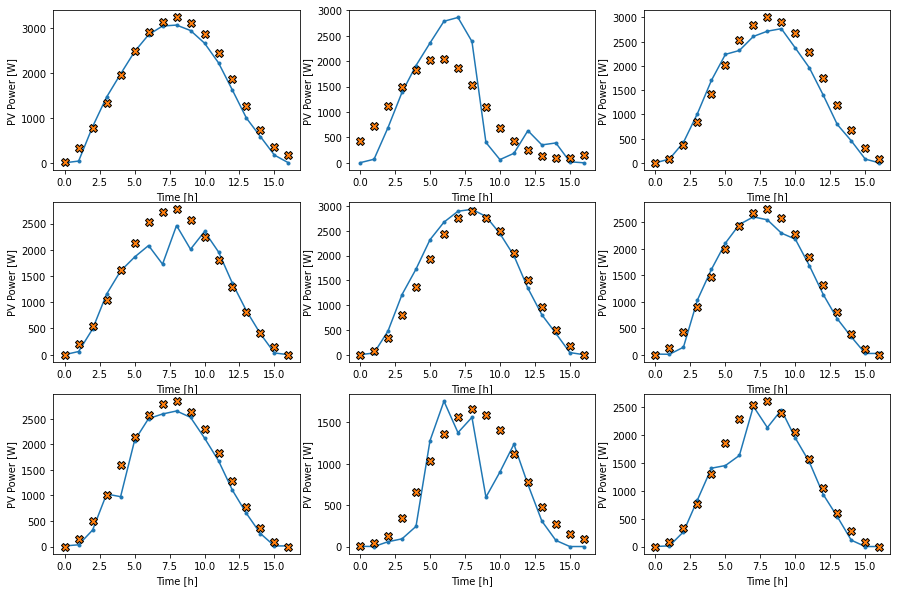

In [129]:
fig = plt.figure(figsize=(15, 10))

for ii in range(9):
    ax = plt.subplot(3, 3, ii+1)
    ax.set_ylabel('PV Power [W]')
    ax.plot(labels[7*ii], marker='.', zorder=-10, label='True Values')
    ax.scatter(x=range(len(scaled_predictions[7*ii])), y=scaled_predictions[7*ii], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
    ax.set_xlabel('Time [h]')

## Next Steps

Possible improvements:

- Model is highly unbalanced for conditions like foggy and snowy
- Model behaves better for training set than validation and test sets
  - Overfitting excluded by swapping training and validation set.
  - Investigate on PV malfunctioning
- Weather history location is about 10 km away from PV system
- Implement models with actual weather forecast rather than weather history